# 00. データを格納するディレクトリ作成

In [3]:
# パッケージのimport
%matplotlib inline

import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms

from PIL import Image, ImageFilter

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


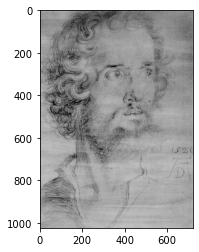

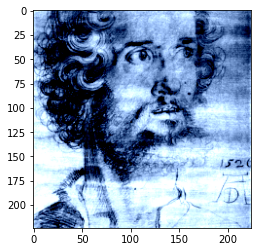

In [4]:
temp_image_path = r".\130081_310927_bundle_archive\images\Albrecht_Durer\Albrecht Durer_1.jpg"
temp_img =  Image.open(temp_image_path)

plt.imshow(temp_img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """
    
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize), # 短い編の大きさが resize の大きさになる
            transforms.CenterCrop(resize), # 画像中央を resize × resize で切り取り
            transforms.ToTensor(), # テンソルへ変換
            transforms.Normalize(mean,std) # 色情報を標準化
        ])
    
    def __call__(self, img):
        return self.base_transform(img)

transform = BaseTransform(resize, mean, std)
img_transformed = transform(temp_img)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)
plt.show()

## X. 対象の芸術家を選定

In [5]:
raw_dir = r"130081_310927_bundle_archive"
fn_artists = r"artists.csv"
fp_artist = os.path.join(raw_dir, fn_artists)
df_artist = pd.read_csv(fp_artist)

df_artist = df_artist[["name","years","genre","nationality","paintings"]]
df_artist = df_artist.sort_values("paintings",ascending = False)
df_artist = df_artist[df_artist["paintings"] > 200]

display(df_artist)

target_artists = df_artist["name"]

,name,years,genre,nationality,paintings
8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,877
30,Edgar Degas,1834 - 1917,Impressionism,French,702
13,Pablo Picasso,1881 - 1973,Cubism,Spanish,439
15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,336
19,Albrecht Durer,1471 - 1528,Northern Renaissance,German,328
46,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,311
16,Francisco Goya,1746 - 1828,Romanticism,Spanish,291
31,Rembrandt,1606 - 1669,Baroque,Dutch,262
20,Alfred Sisley,1839 - 1899,Impressionism,"French,British",259
32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,255


## X. 教師データのコピー

train exists
test exists
label is Vincent van Gogh


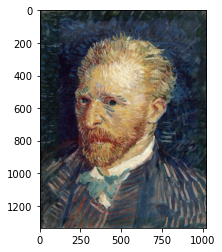

label is Edgar Degas


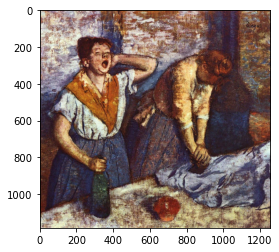

label is Pablo Picasso


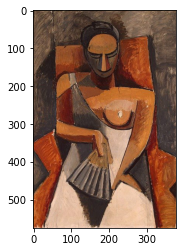

label is Pierre-Auguste Renoir


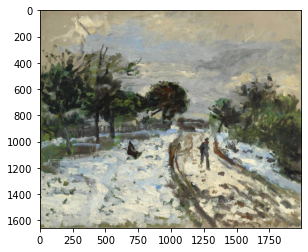

label is Albrecht Durer


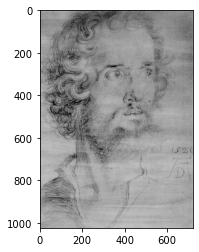

label is Paul Gauguin


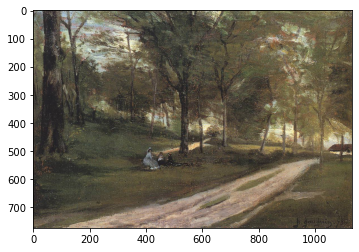

label is Francisco Goya


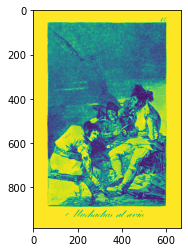

label is Rembrandt


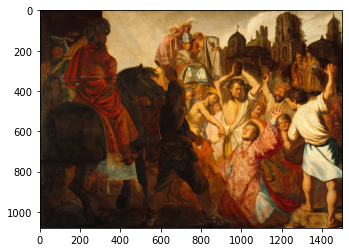

label is Alfred Sisley


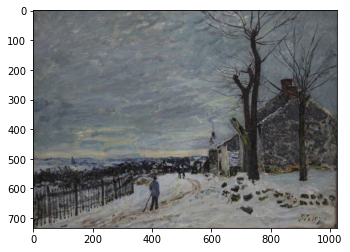

label is Titian


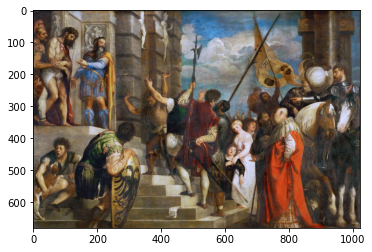

label is Marc Chagall


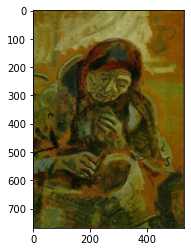

In [16]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir,test_dir = "train","test"

# フォルダ「data」配下に「train\test」が存在しない場合は作成する
for fp in [train_dir, test_dir]:
    if not os.path.exists(os.path.join(data_dir,fp)):
        print(f"{fp} does not exists")
        os.mkdir(os.path.join(data_dir,fp))
    else:
        print(f"{fp} exists")
        
# labelデータを作成します。
for fn_artist in target_artists:
    print(f"label is {fn_artist}")
    # label名のついたディレクトリ
    fp_raw_data = os.path.join("130081_310927_bundle_archive","images",fn_artist.replace(" ","_"))
    
    file_list = [f for f in os.listdir(fp_raw_data) if os.path.isfile(os.path.join(fp_raw_data, f))]
    
    for fp in [train_dir, test_dir]:
        if not os.path.exists(os.path.join(data_dir,fp,fn_artist.replace(" ","_"))):
            os.mkdir(os.path.join(data_dir,fp,fn_artist.replace(" ","_"))) 
        
        if fp == train_dir:
            target_file_list = file_list[:160]
            
            # sampleの表示
            temp_image_path = os.path.join("130081_310927_bundle_archive","images",fn_artist.replace(" ","_"),file_list[0])
            temp_img =  Image.open(temp_image_path)
            plt.imshow(temp_img)
            plt.show()

        else:
            target_file_list = file_list[160:200]
        
        for file_name in target_file_list:
            full_file_name = os.path.join(fp_raw_data, file_name)
            if os.path.isfile(full_file_name):
                shutil.copy(full_file_name, os.path.join(data_dir,fp,fn_artist.replace(" ","_"),file_name))

In [17]:
# 文字化けをするファイル名の変更
def find_all_files(directory):
    for root, dirs, files in os.walk(directory):
        yield root
        for file in files:
            yield os.path.join(root, file)

for file in find_all_files(raw_dir):
#     print(file)
    file_decode = file.replace('Albrecht_Duﾌ・er', 'Albrecht Durer')
#     print(file_decode)
    if file != file_decode:
        os.rename(file,file_decode)